In [12]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
%matplotlib inline

import json
import baltic as bt
from scipy.stats import linregress
import numpy as np
import pandas as pd
from itertools import combinations
import pickle

In [2]:
out_path = './png/'
colors = pickle.load(open('./colors.p', 'r'))

all_tree_file = '../data/augur-output/dengue_allBranchEffects_tree.json'
all_tree = bt.loadJSON(all_tree_file, {'name': 'strain', 'height': 'xvalue'})


Tree height: 0.335580
Tree length: 7.088900
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)



In [3]:
# def antigenically_uniform(node, tree):
#     descendants = [k for k in tree.traverse_tree(node, include_all=True)]
#     trait_values = [k.traits['cTiter'] for k in descendants]
#     if len(set(trait_values)) > 1:
#         return False
#     else:
#         return True

# uniform_nodes = [k for k in sorted(all_tree.Objects, key=lambda k: k.height) if antigenically_uniform(k, all_tree)]
# uniform_mrcas = [k for k in uniform_nodes if k.parent not in uniform_nodes and k.branchType=='node']

# for k in uniform_mrcas:
#     all_tree.collapseSubtree(k, k.traits['clade'])

In [8]:
def plot_tree(ll, ax, cax, colorby='cTiter', cmap=colors['cmap']):
    sns.set(style='white')

    max_c = max([k.traits[colorby] for k in ll.Objects if colorby in k.traits ])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_c)
    cb = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, orientation='vertical', 
                                   norm=norm, label="Cumulative log2(titer) distance from root")    
    cax.yaxis.set_label_position('left')
    cax.yaxis.set_ticks_position('left')

    cb.set_label("Cumulative log2(titer) distance from root", )

    branchWidth=2 ## default branch width
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or from x position determined earlier
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c=cmap(k.traits[colorby]/max_c) ## or be a function of something else

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            try:
                s = k.width
            except:
                s=50 ## tip size can be fixed
                s=50-30*k.height/ll.treeHeight

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.set_yticks([])
    ax.set_xticks([round(x, 2) for x in np.linspace(0, ll.treeHeight, 5)])
    ax.set_ylim(-5,ll.ySpan+7)
    ax.set_xlabel('Substitutions per site')

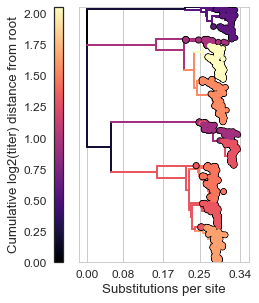

In [17]:
sns.set(style='whitegrid', font_scale=1.2, palette=colors['cmap'])
cmap = plt.get_cmap(colors['cmap'])
fig, (cax, ax) = plt.subplots(nrows=1, ncols=2, figsize=(7.5/2, 8.75/2), gridspec_kw={'width_ratios': (0.05, 1.)}) # quarter page

plot_tree(all_tree, ax=ax, cax=cax, cmap=cmap)
plt.tight_layout()#h_pad=1.08, w_pad=0.5)
plt.show()